In [84]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import seaborn as sns

In [85]:
#Загрузка данных
ratings = pd.read_csv('data/ratings.csv', parse_dates=['timestamp'])

In [86]:
#Ввиду слабого железа я не могу работать с полным датасетом, поэтому оставляю оценки только 20% пользователей
rand_userIds = np.random.choice(ratings['userId'].unique(), 
                                size=int(len(ratings['userId'].unique())*0.2), 
                                replace=False)

ratings = ratings.loc[ratings['userId'].isin(rand_userIds)]

In [87]:
ratings.sample(5)

,userId,movieId,rating,timestamp
15122851,154554,74458,5.0,1466624196
5908850,60802,447,3.0,850302201
20353590,207590,7160,3.5,1108485486
14535757,148819,3699,3.0,1297515053
17562890,179488,2243,5.0,938808639


EDA

In [88]:
ratings.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5531176 entries, 0 to 27753330
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     5531176 non-null  int64  
 1   movieId    5531176 non-null  int64  
 2   rating     5531176 non-null  float64
 3   timestamp  5531176 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 211.0+ MB


Во всё датафрейме нет никаких пропусков

In [89]:
ratings.describe()

,userId,movieId,rating
count,5.531176e+06,5.531176e+06,5.531176e+06
mean,1.414796e+05,1.820828e+04,3.526433e+00
std,8.168393e+04,3.481534e+04,1.066835e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,7.154150e+04,1.097000e+03,3.000000e+00
50%,1.410610e+05,2.707000e+03,3.500000e+00
75%,2.116110e+05,7.082000e+03,4.000000e+00
max,2.832270e+05,1.938860e+05,5.000000e+00


Средняя оценка среди всех пользователей = 3.54

<AxesSubplot:xlabel='rating', ylabel='count'>

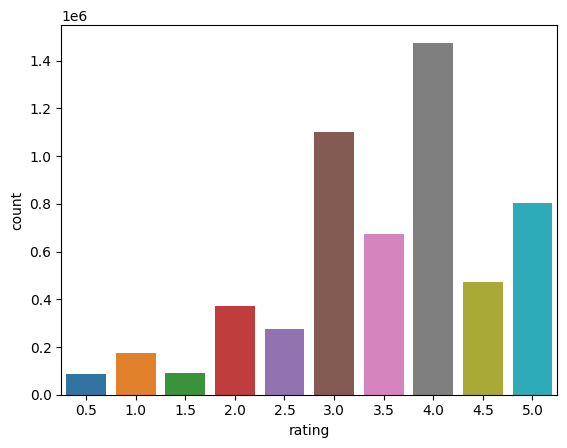

In [90]:
sns.countplot(x='rating', data=ratings)

Чаще всего пользователи ставят оценки 4.0, 3.0 и 5.0

In [91]:
# Пользователь с самым большим количеством отзывов
ratings[ratings['userId']==242683]

,userId,movieId,rating,timestamp
23750344,242683,1,5.0,1160463838
23750345,242683,2,3.0,1160533952
23750346,242683,3,2.5,1163336461
23750347,242683,5,1.5,1163336723
23750348,242683,6,4.0,1160532816
...,...,...,...,...
23757854,242683,93116,3.0,1344823537
23757855,242683,93838,4.5,1336287562
23757856,242683,95588,3.0,1359355785
23757857,242683,99114,3.0,1423722951


In [92]:
# Ранжирование пользователей по количеству оценок
rank_per_user = ratings.groupby('userId')['rating'].count().sort_values(ascending=False)
rank_per_user

userId
242683    7515
111908    6645
172357    5868
48470     5257
94843     5130
          ... 
274762       1
253550       1
58501        1
222651       1
212474       1
Name: rating, Length: 56645, dtype: int64

In [93]:
# 2 столбец - количество пользователей оставивиших столько-то оценок
# 1-й столбец - количество оценок
ratings.groupby('userId')['rating'].count().value_counts().sort_index()

1       1142
2        786
3        715
4        606
5       1545
        ... 
5130       1
5257       1
5868       1
6645       1
7515       1
Name: rating, Length: 1359, dtype: int64

Много пользователей соверишвших малое количество взаимодействий с фильмами. Оставим пользователей, которые оценили хотя бы 5 фильмов.

In [94]:
active_users = list(rank_per_user.where(rank_per_user>=5).dropna().index)
ratings = ratings[ratings['userId'].isin(active_users)]
ratings.shape

(5523893, 4)

Разбиение на тренировочную-тестовую выборку. В качестве тестовой выборки будет выступать последний фильм, чтобы не возникало ситуаций посмотренный пользователем, так как в случае случайного разбиения могут возникнуть "утечки данных". То есть может получиться, что для обучения модели мы используем данные которые появились позже тестовой выборки.

In [95]:
#Составляется набор данных по последним оценкам пользователя
ratings['rank_last'] = ratings.groupby(['userId'])['timestamp'].rank(method='first', ascending=False)

train_ratings = ratings[ratings['rank_last'] != 1].drop(['timestamp', 'rank_last'], axis=1)
test_ratings = ratings[ratings['rank_last'] == 1].drop(['timestamp', 'rank_last'], axis=1)

Основано на Implicit feedback, то есть будем смотреть на то, что пользователь взаимодействовал с фильмом, в данном случае, если пользователь поставил оценку, то ставится 1, в противном случае 0

In [96]:
#Превращение всех оценок в 1
train_ratings.loc[:, 'rating'] = 1

train_ratings.sample(5)

,userId,movieId,rating
18261184,186434,67197,1
8101667,83400,6281,1
26675744,272360,105504,1
21338138,217979,95441,1
15044242,153795,3578,1


Однако в наборе данных остались только положительные примеры (пользователь взаимодействовал с фильмом), надо добавить и отрицательные. Заодно преобразуем датасет в формат PyTorch

In [97]:
class MovieLensTrainDataset(Dataset):
    """MovieLens PyTorch Dataset for Training
    
    Args:
        ratings (pd.DataFrame): Датафрейм, содержащий оценки фильмов
        all_movieIds (list): Лист всех id фильмов
    
    """

    def __init__(self, ratings, all_movieIds):
        self.users, self.items, self.labels = self.get_dataset(ratings, all_movieIds)

    def __len__(self):
        return len(self.users)
  
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, ratings, all_movieIds):
        users, items, labels = [], [], []
        user_item_set = set(zip(ratings['userId'], ratings['movieId']))

        # Число негативных примеров на один позитивный,
        # Таким образомсоотношение позитивных к негативным равно 1:4
        num_negatives = 4
        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            # Пометка полож. примера
            labels.append(1)
            for _ in range(num_negatives):
                # Выбор случайного фильма с которым юзер не взаимодействовал
                negative_item = np.random.choice(all_movieIds)
                # Проверка на наличие такой пары пользователь, фильм в датасете
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(negative_item)
                # Пометка отриц. примера
                labels.append(0)

        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

In [98]:
class NCF(pl.LightningModule):
    """ Neural Collaborative Filtering (NCF)
    
        Args:
            num_users (int): Число уникальных пользователей
            num_items (int): Число уникальных фильмов
            ratings (pd.DataFrame): Датафрейм с пользовательскими рейтингами фильмов для обучения
            all_movieIds (list): Лист всех id фильмов
    """
    
    def __init__(self, num_users, num_items, ratings, all_movieIds):
        super().__init__()
        # Создание слоя эмбеддингов для пользователей и фильмов
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        # Создание двух полносвязных слоёв
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)

        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings = ratings
        self.all_movieIds = all_movieIds
        
    def forward(self, user_input, item_input):
        
        # Проход через слой эмбеддингов
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Объединение слоев эмбеддингов
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Проход через полносвязные слои
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))

        # Выходной слой с применением сигмоидальной функции
        pred = nn.Sigmoid()(self.output(vector))

        return pred
    
    def training_step(self, batch):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        #В качестве функции потерь используется Binary Cross Entropy
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(MovieLensTrainDataset(self.ratings, self.all_movieIds),
                          batch_size=1024, shuffle=False)

In [99]:
num_users = ratings['userId'].max()+1
num_items = ratings['movieId'].max()+1

all_movieIds = ratings['movieId'].unique()

model = NCF(num_users, num_items, train_ratings, all_movieIds)

In [100]:
trainer = pl.Trainer(max_epochs=5, 
                     enable_progress_bar=True, 
                     enable_checkpointing=True,
                     reload_dataloaders_every_n_epochs=1
                     )

trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.3 M 
1 | item_embedding | Embedding | 1.6 M 
2 | fc1            | Linear    | 1.1 K 
3 | fc2            | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
3.8 M     Trainable params
0         Non-trainable params
3.8 M     Total params
15.280    Total estimated model params size (MB)
c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve 

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Тетсирование работы модели. Тестовая выборка строится следующим образом - Для каждого пользователя выбираются 99  случайных фильмов, с которыми он не взаимодействовал и один фильм из тестовой выборки. Затем выборка из этих фильмов ранжируется и на рекоммендации остаются 10 фильмов. Для оценки модели используется метрика Hit Ratio @ 10, в итоге будет видно для какого процента пользователей модель порекоммендовала тестовый фильм.

In [103]:
# Пара пользователь - тестовый фильм
test_user_item_set = set(zip(test_ratings['userId'], test_ratings['movieId']))

# Словарь со всеми взаимодействиями пользователей
user_interacted_items = ratings.groupby('userId')['movieId'].apply(list).to_dict()

hits = []
for (u,i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_movieIds) - set(interacted_items)
    # Выбираем 99 фильмов, с которыми пользователь не взаимодействовал
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]
    
    # Ранжирование фильмов
    predicted_labels = np.squeeze(model(torch.tensor([u]*100), 
                                        torch.tensor(test_items)).detach().numpy())

    #Топ-10 рекоммендаций
    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    if i in top10_items:
        hits.append(1)
    else:
        hits.append(0)

hit_rate = np.average(hits)
print(f'Hit Ratio @ 10 = {hit_rate}')

  0%|          | 0/53396 [00:00<?, ?it/s]

Hit Ratio @ 10 = 0.8981946213199491


В итоге получился Hit Ratio @ 10 = 0.8981946213199491, что означает, что для почти 90% пользователей среди 10 фильмов, рекомендованных моделью, был фильм, с которым пользователь точно контактировал.